# W3_Clustering Text Data with K-Means

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import os
import sys
import time

In [2]:
data = pd.read_csv('people_wiki.csv')
data.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [3]:
ser = pd.read_json('people_wiki_map_index_to_word.json', typ='series')
map_index_to_word = pd.DataFrame(ser, columns=['word_index'])
map_index_to_word['word'] = map_index_to_word.index
map_index_to_word.index = map_index_to_word['word_index']
map_index_to_word.drop('word_index', axis=1, inplace=True)
map_index_to_word.head()

,word
word_index,
540315,0
536260,00
535641,000
83348,0000
81527,00000


In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    return csr_matrix( (data, indices, indptr), shape)

tf_idf_matrix = load_sparse_csr('people_wiki_tf_idf.npz')
tf_idf_matrix # sparse matrix with 59071 data points, 547979 features

<59071x547979 sparse matrix of type '<class 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [5]:
tf_idf_matrix = normalize(tf_idf_matrix, axis=1)

In [6]:
def get_initial_centroids(data, k, seed=None):
    # randomly choose k data points as initial centroids
    if seed is not None: 
        np.random.seed(seed)
    
    n = data.shape[0]
    indexes = np.random.randint(0, n, k)
    centroids = data[indexes,:].toarray() # dense array
    return centroids # k * d

In [7]:
#
c = tf_idf_matrix[0:3]
dist = pairwise_distances(tf_idf_matrix, c)
dist.shape

(59071, 3)

In [8]:
def assign_clusters(data, centroids):
    '''
    data: n * d
    centroids: k * d
    '''
    distances_from_centroids = pairwise_distances(data, centroids) # n * k
    cluster_assignment = np.argmin(distances_from_centroids, axis=1) # n * 1
    return cluster_assignment 

In [9]:
#
assign_clusters(tf_idf_matrix[100:120], tf_idf_matrix[0:3])

array([2, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2], dtype=int64)

In [10]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        member_data_points = data[cluster_assignment==i]
        centroid = member_data_points.mean(axis=0)
        centroid = centroid.A1 # 1-d nparray
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids) # k * d
    return new_centroids

In [11]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    heterogeneity = 0.0
    for i in range(k):
        member_data_points = data[cluster_assignment==i]
        if member_data_points.shape[0] > 0: 
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)        
    return heterogeneity

In [12]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        cluster_assignment = assign_clusters(data, centroids)
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # check for convergence
        if prev_cluster_assignment is not None and (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # count new assignments
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('  {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # record heterogeneity convergence metric
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [13]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

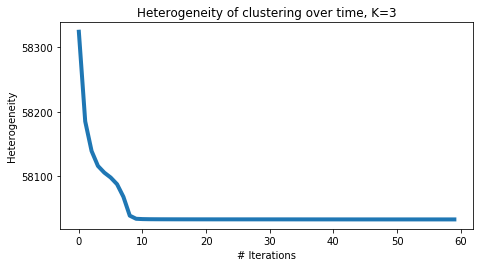

In [14]:
# k=3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf_matrix, 3, seed=0)
centroids, cluster_assignment = kmeans(tf_idf_matrix, 3, initial_centroids, maxiter=400, record_heterogeneity=heterogeneity)
plot_heterogeneity(heterogeneity, 3)

In [15]:
# compute which cluster has the most data points
for i in range(3):
    print('cluster {}: {}'.format(i, np.sum(cluster_assignment==i)))

cluster 0: 19595
cluster 1: 10427
cluster 2: 29049


In [16]:
# run k-means with different initial centroids created using different random seeds
# k=10
heterogeneity = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf_matrix, 10, seed)
    centroids, cluster_assignment = kmeans(tf_idf_matrix, 10, initial_centroids, maxiter=400)
    # to save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf_matrix, 10, centroids, cluster_assignment)
    biggest_cluster = np.argmax(np.bincount(cluster_assignment))
    num_in_biggest_cluster = np.sum(cluster_assignment==biggest_cluster)
    print('seed={}, heterogeneity={}, data points in the biggest cluster={}'.format(seed, heterogeneity[seed], num_in_biggest_cluster))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=0, heterogeneity=57457.52442292027, data points in the biggest cluster=18047
seed=20000, heterogeneity=57533.20099687315, data points in the biggest cluster=15779
seed=40000, heterogeneity=57512.692572562795, data points in the biggest cluster=18132
seed=60000, heterogeneity=57466.97924645124, data points in the biggest cluster=17900
seed=80000, heterogeneity=57494.92989694541, data points in the biggest cluster=17582
seed=100000, heterogeneity=57484.42209612294, data points in the biggest cluster=16969
seed=120000, heterogeneity=57554.624099931665, data points in the biggest cluster=16481
547.170036315918


In [17]:
# k-means++ to initialize a good set of centroids
def smart_initialize(data, k, seed=None):
    if seed is not None: 
        np.random.seed(seed)
        
    centroids = np.zeros((k, data.shape[1]))
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2, axis=1)
    return centroids

In [18]:
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf_matrix, 10, seed)
    centroids, cluster_assignment = kmeans(tf_idf_matrix, 10, initial_centroids, maxiter=400)
    # to save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf_matrix, 10, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
719.8264513015747


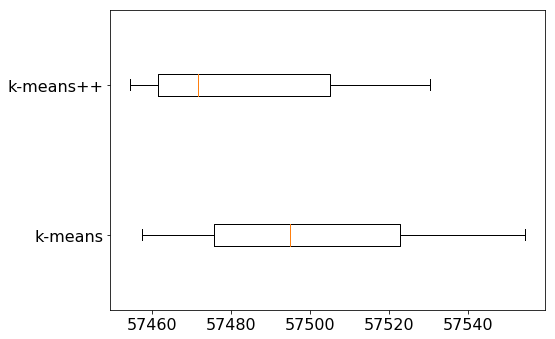

In [19]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [20]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    best_centroids = None
    best_cluster_assignment = None
    
    for i in range(num_runs):
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        initial_centroids = get_initial_centroids(data, k)
        centroids, cluster_assignment = assign_clusters(data, initial_centroids)
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()

        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            best_centroids = centroids
            best_cluster_assignment = cluster_assignment
    
    return best_centroids, best_cluster_assignment

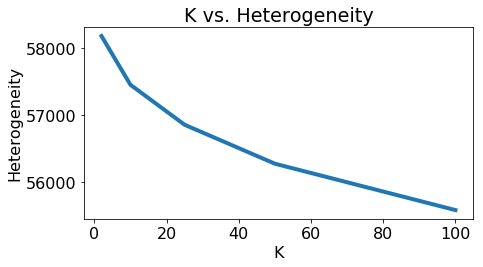

In [21]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        sys.stdout.flush()
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf_matrix, k, centroids[k], cluster_assignment[k])
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In [22]:
def visualize_document_clusters(centroids, k, map_index_to_word):
    print('==========================================================')
    for cluster_index in range(k):
        print('# Cluster', cluster_index)
        # top 5 words with largest TF-IDF weights in the cluster
        indexes = centroids[cluster_index].argsort()[::-1][:5]
        for i in range(5): # print each word along with the TF-IDF weight
            print('{0}: {1:.3f}'.format(map_index_to_word.loc[indexes[i]]['word'], centroids[cluster_index, indexes[i]]))
        print('==========================================================')

In [23]:
visualize_document_clusters(centroids[2], 2, map_index_to_word)

# Cluster 0
she: 0.025
her: 0.017
music: 0.012
he: 0.011
university: 0.011
# Cluster 1
league: 0.040
season: 0.036
team: 0.029
football: 0.029
played: 0.028


In [24]:
visualize_document_clusters(centroids[10], 10, map_index_to_word)

# Cluster 0
film: 0.020
art: 0.014
he: 0.011
book: 0.010
television: 0.010
# Cluster 1
league: 0.052
rugby: 0.044
club: 0.042
cup: 0.042
season: 0.041
# Cluster 2
championships: 0.040
tour: 0.037
championship: 0.032
world: 0.029
won: 0.029
# Cluster 3
baseball: 0.110
league: 0.103
major: 0.052
games: 0.047
season: 0.045
# Cluster 4
research: 0.038
university: 0.035
professor: 0.032
science: 0.023
institute: 0.019
# Cluster 5
football: 0.076
coach: 0.060
basketball: 0.056
season: 0.044
played: 0.037
# Cluster 6
she: 0.138
her: 0.089
actress: 0.014
film: 0.013
miss: 0.012
# Cluster 7
music: 0.057
album: 0.040
band: 0.035
orchestra: 0.023
released: 0.022
# Cluster 8
hockey: 0.216
nhl: 0.134
ice: 0.065
season: 0.053
league: 0.047
# Cluster 9
party: 0.028
election: 0.025
minister: 0.025
served: 0.021
law: 0.019


In [25]:
# compute cluster which contains the greatest/least number of articles
cluster_assignment[10]
biggest_cluster = np.argmax(np.bincount(cluster_assignment[10]))
smallest_cluster = np.argmin(np.bincount(cluster_assignment[10]))
print(biggest_cluster)
print(smallest_cluster)

0
8


In [26]:
visualize_document_clusters(centroids[25], 25, map_index_to_word)

# Cluster 0
law: 0.077
district: 0.048
court: 0.046
republican: 0.038
senate: 0.038
# Cluster 1
research: 0.054
professor: 0.033
science: 0.032
university: 0.031
physics: 0.029
# Cluster 2
hockey: 0.216
nhl: 0.134
ice: 0.065
season: 0.052
league: 0.047
# Cluster 3
party: 0.065
election: 0.042
elected: 0.031
parliament: 0.027
member: 0.023
# Cluster 4
board: 0.025
president: 0.023
chairman: 0.022
business: 0.022
executive: 0.020
# Cluster 5
minister: 0.160
prime: 0.056
cabinet: 0.044
party: 0.043
election: 0.042
# Cluster 6
university: 0.044
professor: 0.037
studies: 0.035
history: 0.034
philosophy: 0.031
# Cluster 7
election: 0.066
manitoba: 0.058
liberal: 0.051
party: 0.045
riding: 0.043
# Cluster 8
racing: 0.095
formula: 0.056
championship: 0.054
race: 0.052
poker: 0.051
# Cluster 9
economics: 0.146
economic: 0.096
economist: 0.053
policy: 0.048
research: 0.043
# Cluster 10
championships: 0.075
olympics: 0.050
marathon: 0.048
metres: 0.048
she: 0.048
# Cluster 11
she: 0.144
her: 0.09

In [27]:
# compute how many clusters have fewer than 236 articles (0.4% of the dataset) (k = 100)
cluster_num = 0
for i in range(100):
    num = np.sum(cluster_assignment[100]==i)
    if num < 236:
        cluster_num += 1
cluster_num

29